In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
sys.path.insert(0,'/content/drive/My Drive/Colab_Notebooks/RecSys')

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms as T

from model.autoencoders import ConvVAE, LinearVAE, loss_vae

In [4]:
!nvidia-smi

Mon Jul 25 19:21:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    11W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
paths_pairs_bot = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/RecSys/arrays/paths_pairs_bot.csv', index_col=0)
paths_pairs_shoes = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/RecSys/arrays/paths_pairs_shoes.csv', index_col=0)

In [6]:
#top_photos = np.load('/content/drive/MyDrive/Colab_Notebooks/RecSys/arrays/top_photos.npy', allow_pickle=True)
#bot_photos = np.load('/content/drive/MyDrive/Colab_Notebooks/RecSys/arrays/bot_photos.npy', allow_pickle=True) #mmap_mode='c'
bot_photos_shoes = np.load('/content/drive/MyDrive/Colab_Notebooks/RecSys/arrays/bot_photos_shoes.npy', allow_pickle=True)
shoes_photos = np.load('/content/drive/MyDrive/Colab_Notebooks/RecSys/arrays/shoes_photos.npy', allow_pickle=True)

In [7]:
#train_photos_top, val_photos_top = train_test_split(top_photos, train_size=0.9, shuffle=False)
#train_photos_bot, val_photos_bot = train_test_split(bot_photos, train_size=0.9, shuffle=False)
train_photos_bot_shoes, val_photos_bot_shoes = train_test_split(bot_photos_shoes, train_size=0.9, shuffle=False)
train_photos_shoes, val_photos_shoes = train_test_split(shoes_photos, train_size=0.9, shuffle=False)

bs = 32

#train_loader_top = torch.utils.data.DataLoader(train_photos_top, batch_size=bs)
#val_loader_top = torch.utils.data.DataLoader(val_photos_top, batch_size=bs)

#train_loader_bot = torch.utils.data.DataLoader(train_photos_bot, batch_size=bs)
#val_loader_bot = torch.utils.data.DataLoader(val_photos_bot, batch_size=bs)

train_loader_bot_shoes = torch.utils.data.DataLoader(train_photos_bot_shoes, batch_size=bs)
val_loader_bot_shoes = torch.utils.data.DataLoader(val_photos_bot_shoes, batch_size=bs)

train_loader_shoes = torch.utils.data.DataLoader(train_photos_shoes, batch_size=bs)
val_loader_shoes = torch.utils.data.DataLoader(val_photos_shoes, batch_size=bs)

In [8]:
pairs_bot = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/RecSys/arrays/pairs_bot.csv', index_col=0)
pairs_shoes = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/RecSys/arrays/pairs_shoes.csv', index_col=0)

In [10]:
# indices for metrics
top_indices = pairs_bot.top.values
bot_indices = pairs_bot.bottom.values

bot_shoes_indices = pairs_shoes.bottom.values
shoes_indices = pairs_shoes.shoes.values

In [11]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [10]:
vae_bot = ConvVAE().to(device)
optimizer = torch.optim.AdamW(vae_bot.parameters(), lr=3e-4) 

In [41]:
vae_bot

ConvVAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1, inplace=True)
    (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.1, inplace=True)
    (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.1, inplace=True)
    (12): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [12]:
# code for checking correctness of output image after convolutions
for idx, images in enumerate(train_loader_top):
    images = images.permute(0,3,1,2).to(device, dtype=torch.float)
    recon_images, mu, logvar = vae_bot(images)
    print(images.shape)
    print(recon_images.shape)
    break

torch.Size([32, 3, 128, 128])
torch.Size([32, 3, 128, 128])


In [13]:
# training model for generating bot
epochs = 30
train_losses = []

for epoch in tqdm(range(epochs)):
    vae_bot.train()
    train_losses_per_epoch = []
    for images, images_bot in zip(train_loader_top, train_loader_bot):
        optimizer.zero_grad()
        images = images.to(device, dtype=torch.float)
        images = images.permute(0,3,1,2).to(device, dtype=torch.float)
        images_bot = images_bot.permute(0,3,1,2).to(device, dtype=torch.float)
        recon_images, mu, logvar = vae_bot(images)
        loss = loss_vae(images_bot, mu, logvar, recon_images)
        
        loss.backward()
        optimizer.step()

        train_losses_per_epoch.append(loss.item())
        
    print(f"Epoch: {epoch+1}/{epochs} Loss: {np.mean(train_losses_per_epoch)}")
    train_losses.append(np.mean(train_losses_per_epoch))  

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1/30 Loss: 729941.65625
Epoch: 2/30 Loss: 436722.14660493826
Epoch: 3/30 Loss: 360154.5486111111
Epoch: 4/30 Loss: 332865.47067901236
Epoch: 5/30 Loss: 320878.75231481483
Epoch: 6/30 Loss: 313526.0547839506
Epoch: 7/30 Loss: 308024.7260802469
Epoch: 8/30 Loss: 303928.96875
Epoch: 9/30 Loss: 300796.58294753084
Epoch: 10/30 Loss: 297499.2472993827
Epoch: 11/30 Loss: 294642.1618441358
Epoch: 12/30 Loss: 292022.95659722225
Epoch: 13/30 Loss: 289281.92380401236
Epoch: 14/30 Loss: 287038.918595679
Epoch: 15/30 Loss: 284942.44193672837
Epoch: 16/30 Loss: 282306.58719135803
Epoch: 17/30 Loss: 280473.74710648146
Epoch: 18/30 Loss: 278832.82118055556
Epoch: 19/30 Loss: 277082.369212963
Epoch: 20/30 Loss: 275582.14313271607
Epoch: 21/30 Loss: 274252.0262345679
Epoch: 22/30 Loss: 272986.91550925927
Epoch: 23/30 Loss: 270828.17438271607
Epoch: 24/30 Loss: 269938.72106481483
Epoch: 25/30 Loss: 268576.7617669753
Epoch: 26/30 Loss: 267375.2824074074
Epoch: 27/30 Loss: 265457.16898148146
Epoch: 

In [108]:
result_list = []
ground_truth_list = []
orig_list = []

vae_bot.eval()
with torch.inference_mode():
    for batch_top, batch_bot in zip(val_loader_top, val_loader_bot):
        
        batch_top = batch_top.permute(0,3,1,2).to(device, dtype=torch.float)
        reconstruction, mu, logsigma = vae_bot(batch_top.to(device))
        
        result_list.append(reconstruction.cpu().detach().numpy()) # generated img
        ground_truth_list.append(batch_bot.cpu().numpy()) # bot image
        orig_list.append(batch_top.cpu().numpy()) # top image

In [109]:
result = np.append(result_list[0], result_list[1], axis=0)
ground_truth = np.append(ground_truth_list[0], ground_truth_list[1], axis=0)
orig = np.append(orig_list[0], orig_list[1], axis=0)

for i in range(2, len(val_loader_top)):
    result = np.append(result, result_list[i], axis=0)
    ground_truth = np.append(ground_truth, ground_truth_list[i], axis=0)
    orig = np.append(orig, orig_list[i], axis=0)

Get embedding of all bot images to find the most similar.

In [15]:
embeddings_bot = torch.Tensor([]).to(device, dtype=torch.float)
for images_bot in train_loader_bot:
    images_bot = images_bot.to(device, dtype=torch.float)
    images_bot = images_bot.permute(0,3,1,2).to(device, dtype=torch.float)
    embeddings_bot = torch.cat((embeddings_bot, vae_bot.encode(images_bot)[0]), 0) 

for images_bot in val_loader_bot:
    images_bot = images_bot.to(device, dtype=torch.float)
    images_bot = images_bot.permute(0,3,1,2).to(device, dtype=torch.float)
    embeddings_bot = torch.cat((embeddings_bot, vae_bot.encode(images_bot)[0]), 0) 



In [12]:
def find_k_neighbours(k, data, test):
    dist = torch.norm(data - test, dim=1, p=None)
    knn = dist.topk(k, largest=False)

    return knn.indices

In [110]:
result_tensor = torch.Tensor(result).to(device, dtype=torch.float)
embed = vae_bot.encode(result_tensor)[0]
embed

tensor([[ 0.8950, -0.1453,  0.2764,  ..., -0.2653, -0.1157, -1.3984],
        [-0.6035, -0.2891,  0.0377,  ..., -0.3079, -0.6523, -0.7053],
        [ 0.2451, -1.3143,  1.7314,  ...,  0.0675,  0.3522, -1.2494],
        ...,
        [ 1.5062, -0.6458,  0.4468,  ..., -0.6696,  0.7875, -0.5201],
        [ 0.6331, -2.4394,  0.3534,  ..., -0.4221,  0.1730, -0.9350],
        [ 1.1703, -0.9837,  0.1951,  ...,  0.8704,  1.1606, -0.9313]],
       device='cuda:0', grad_fn=<AddBackward0>)

Metrics:

In [21]:
import random

In [22]:
pairs_bot_list = pairs_bot.groupby('top').aggregate(list)
pairs_shoes_list = pairs_shoes.groupby('bottom').aggregate(list)

In [221]:
metric1_lst = []
for i in range(30):    
    metric = 0
    metric1 = 0
    for i, (org, gt, res, emb, top_idx, bot_idx) in enumerate(zip(orig, 
                                                ground_truth, 
                                                result, 
                                                embed,
                                                top_indices[-len(embed):],
                                                bot_indices[-len(embed):])
    ):
        res = np.moveaxis(res, 0, -1)
        org = np.moveaxis(org, 0, -1)
        indices = find_k_neighbours(30, embeddings_bot, emb)

        neighbours_ids = [bot_indices[index] for index in indices]
        proper_item_ids = pairs_bot_list.query("top == @top_idx").bottom.values[0]
        random_indices = random.sample(list(bot_indices), 30)

        if (len(set(proper_item_ids) & set(neighbours_ids))) != 0:
            metric += 1

        if (len(set(proper_item_ids) & set(random_indices))) != 0:
            metric1 += 1
    
    metric1_lst.append(metric1)

In [223]:
print(f"В {round((metric / 288) * 100, 2)}% случаев алгоритм находит хотя бы один нужный айтем")
print(f"Случайный алгоритм находит хотя бы один айтем в {round((np.mean(metric1_lst) / 288) * 100, 2)}% случаев")

В 6.6% случаев алгоритм находит хотя бы один нужный айтем
Случайный алгоритм находит хотя бы один айтем в 3.32% случаев


Visualization:

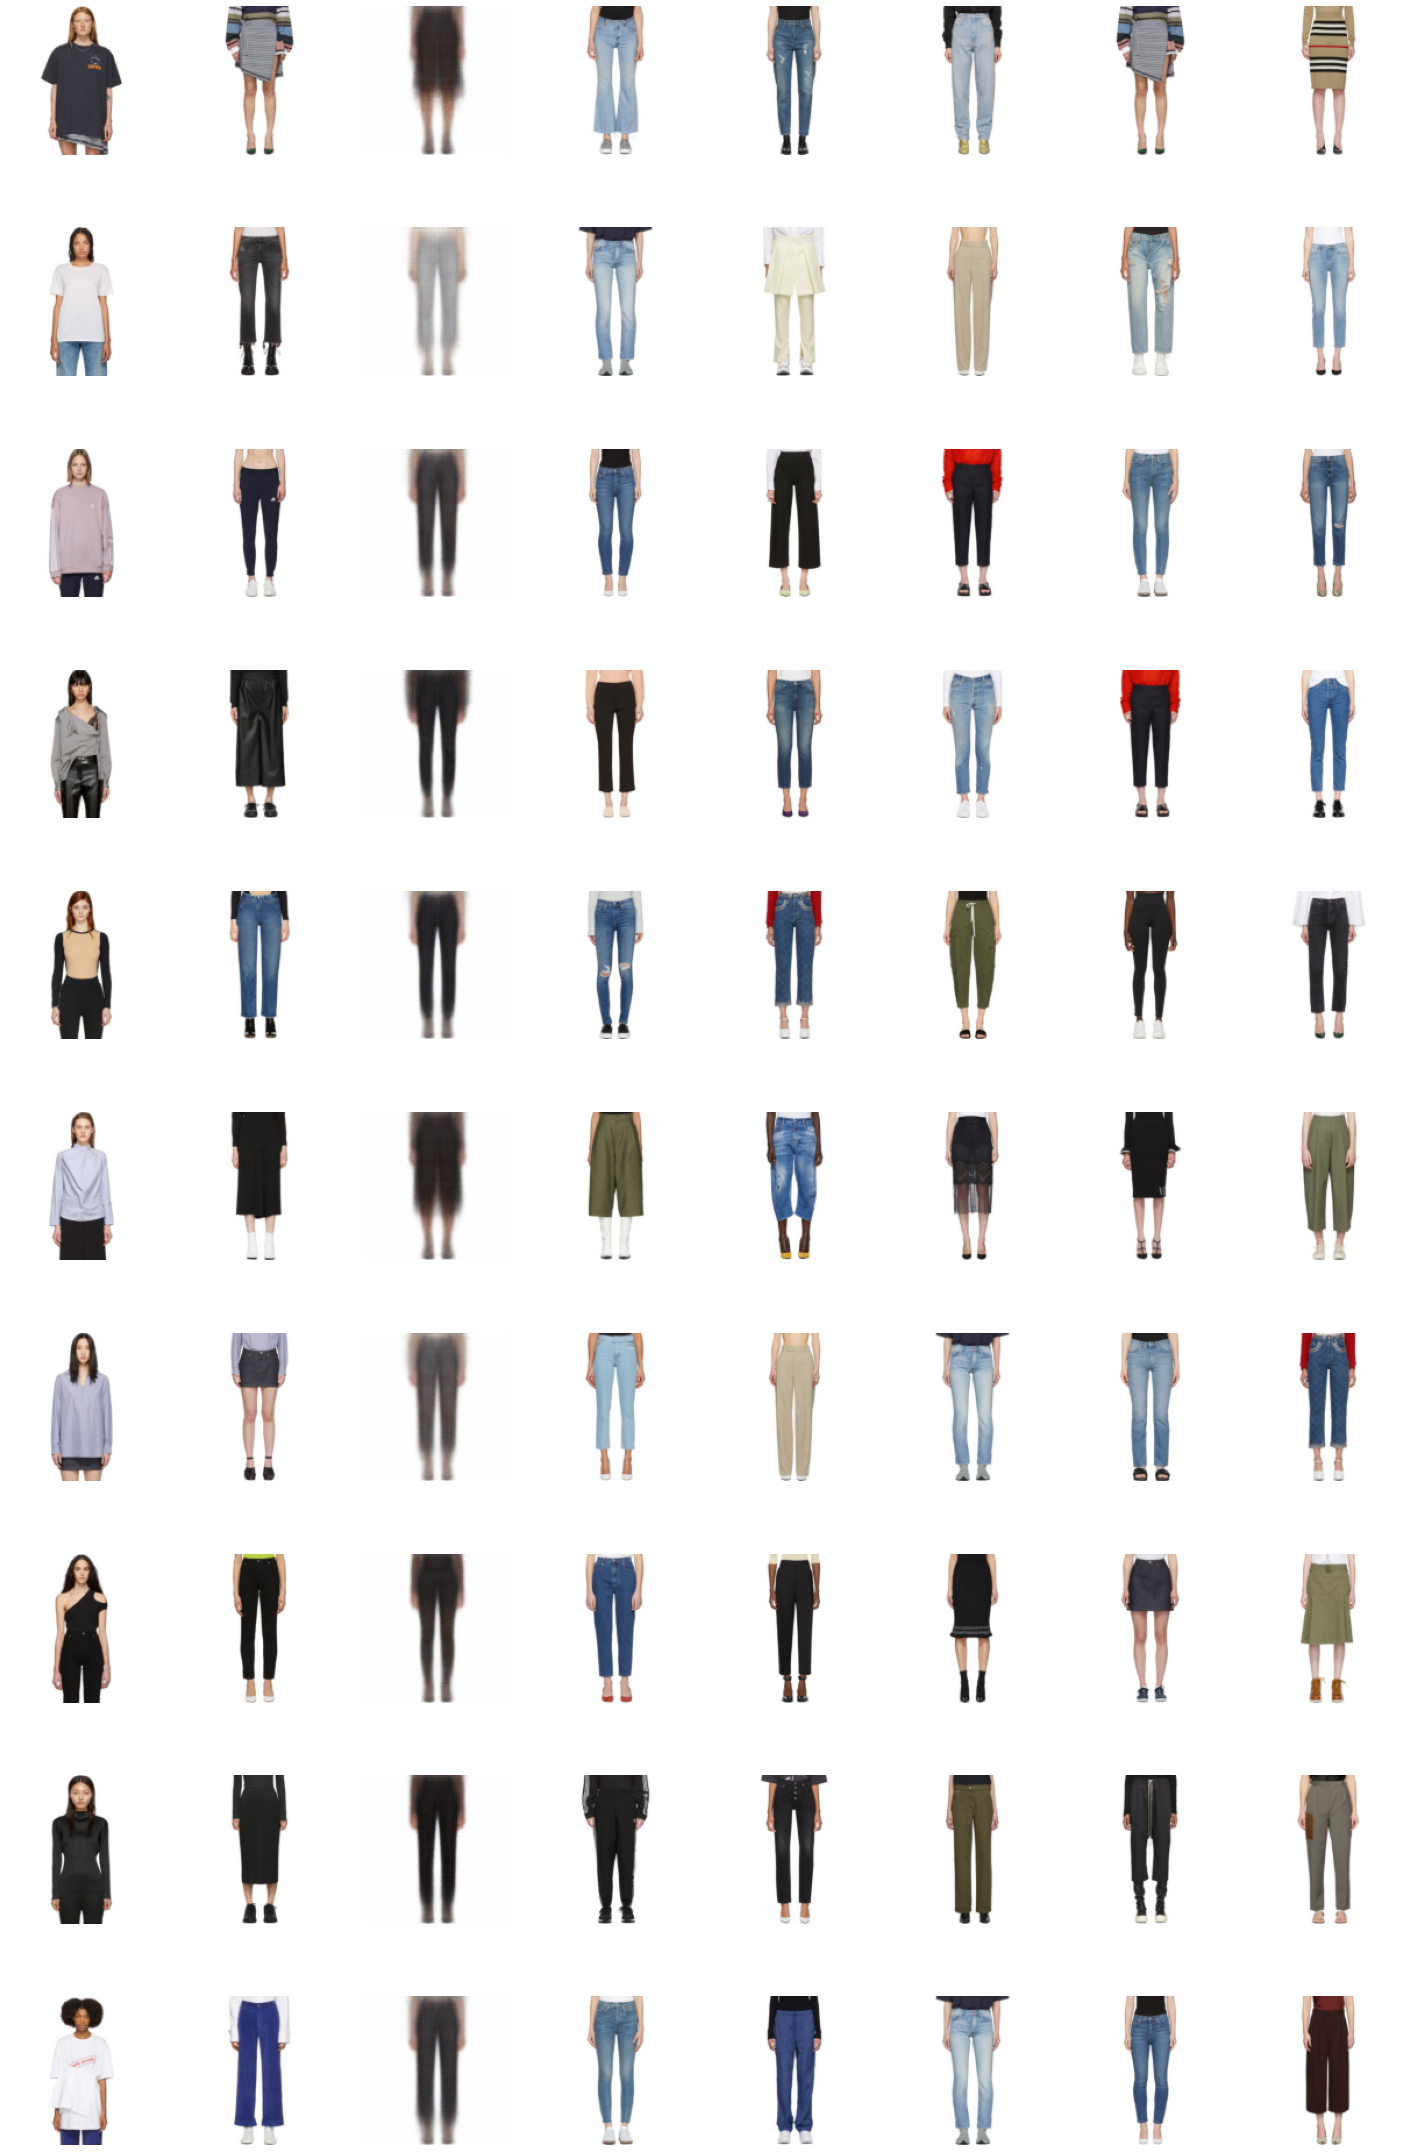

In [111]:
plt.figure(figsize=(25, 40))
k = 10
num_items = 8
for i, (org, gt, res, emb) in enumerate(zip(orig[:k], ground_truth[:k], result[:k], embed[:k])):
    res = np.moveaxis(res, 0, -1)
    org = np.moveaxis(org, 0, -1)

    plt.subplot(10, num_items, num_items*i+1)
    plt.axis('off')
    plt.imshow(org)
    plt.subplot(10, num_items, num_items*i+2)
    plt.axis('off')
    plt.imshow(gt)
    plt.subplot(10, num_items, num_items*i+3)
    plt.imshow(res)
    plt.axis('off')

    # find 5 most similar images and show them
    indices = find_k_neighbours(5, embeddings_bot, emb)
    
    plt.subplot(10, num_items, num_items*i+4)
    plt.axis('off')
    plt.imshow(bot_photos[indices[0]])

    plt.subplot(10, num_items, num_items*i+5)
    plt.axis('off')
    plt.imshow(bot_photos[indices[1]])

    plt.subplot(10, num_items, num_items*i+6)
    plt.axis('off')
    plt.imshow(bot_photos[indices[2]])

    plt.subplot(10, num_items, num_items*i+7)
    plt.axis('off')
    plt.imshow(bot_photos[indices[3]])

    plt.subplot(10, num_items, num_items*i+8)
    plt.axis('off')
    plt.imshow(bot_photos[indices[4]])


In [13]:
vae_shoes = ConvVAE().to(device)
optimizer = torch.optim.AdamW(vae_shoes.parameters(), lr=3e-4) 

In [14]:
# training model for generating shoes
epochs = 30
train_losses = []

for epoch in tqdm(range(epochs)):
    vae_shoes.train()
    train_losses_per_epoch = []
    
    for images, images_bot in zip(train_loader_bot_shoes, train_loader_shoes):
        optimizer.zero_grad()
        images = images.to(device, dtype=torch.float)
        images = images.permute(0,3,1,2).to(device, dtype=torch.float)
        images_bot = images_bot.permute(0,3,1,2).to(device, dtype=torch.float)
        recon_images, mu, logvar = vae_shoes(images)
    
        loss = loss_vae(images_bot, mu, logvar, recon_images)
        
        loss.backward()
        optimizer.step()

        train_losses_per_epoch.append(loss.item())
        
    print(f"Epoch: {epoch+1}/{epochs} Loss: {np.mean(train_losses_per_epoch)}")
    train_losses.append(np.mean(train_losses_per_epoch))

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1/30 Loss: 637650.6552734375
Epoch: 2/30 Loss: 474065.3701171875
Epoch: 3/30 Loss: 459339.727734375
Epoch: 4/30 Loss: 452514.1205078125
Epoch: 5/30 Loss: 446202.46796875
Epoch: 6/30 Loss: 441260.5069335938
Epoch: 7/30 Loss: 435485.6474609375
Epoch: 8/30 Loss: 429285.524609375
Epoch: 9/30 Loss: 423899.9834960938
Epoch: 10/30 Loss: 419294.03076171875
Epoch: 11/30 Loss: 414218.95576171874
Epoch: 12/30 Loss: 407900.8556640625
Epoch: 13/30 Loss: 402521.4505859375
Epoch: 14/30 Loss: 396647.0369140625
Epoch: 15/30 Loss: 389320.50439453125
Epoch: 16/30 Loss: 382476.47529296874
Epoch: 17/30 Loss: 379512.26513671875
Epoch: 18/30 Loss: 373133.4705078125
Epoch: 19/30 Loss: 368596.20869140624
Epoch: 20/30 Loss: 366969.97607421875
Epoch: 21/30 Loss: 366771.1794921875
Epoch: 22/30 Loss: 365159.7138671875
Epoch: 23/30 Loss: 362966.8701171875
Epoch: 24/30 Loss: 357463.11201171874
Epoch: 25/30 Loss: 352093.59541015624
Epoch: 26/30 Loss: 354549.1590820312
Epoch: 27/30 Loss: 353041.9015625
Epoch: 2

In [ ]:
vae_shoes.eval()
with torch.inference_mode():
    for batch, batch_bot in zip(val_loader_bot_shoes, val_loader_shoes):
        batch = batch.permute(0,3,1,2).to(device, dtype=torch.float)
        reconstruction, mu, logsigma = vae_shoes(batch.to(device))
        #reconstruction = reconstruction.view(-1, dimx, dimy, 3)
        result = reconstruction.cpu().detach().numpy()
        ground_truth = batch_bot.cpu().numpy()
        orig = batch.cpu().numpy()
        break

In [15]:
result_list = []
ground_truth_list = []
orig_list = []

vae_shoes.eval()
with torch.inference_mode():
    for batch_bot_shoes, batch_shoes in zip(val_loader_bot_shoes, val_loader_shoes):
        
        batch_bot_shoes = batch_bot_shoes.permute(0,3,1,2).to(device, dtype=torch.float)
        reconstruction, mu, logsigma = vae_shoes(batch_bot_shoes.to(device))
        
        result_list.append(reconstruction.cpu().detach().numpy()) # generated img
        ground_truth_list.append(batch_shoes.cpu().numpy()) # bot image
        orig_list.append(batch_bot_shoes.cpu().numpy()) # top image

In [18]:
result = np.append(result_list[0], result_list[1], axis=0)
ground_truth = np.append(ground_truth_list[0], ground_truth_list[1], axis=0)
orig = np.append(orig_list[0], orig_list[1], axis=0)

for i in range(2, len(val_loader_bot_shoes)):
    result = np.append(result, result_list[i], axis=0)
    ground_truth = np.append(ground_truth, ground_truth_list[i], axis=0)
    orig = np.append(orig, orig_list[i], axis=0)

In [19]:
embeddings_shoes = torch.Tensor([]).to(device, dtype=torch.float)
for images_shoes in train_loader_shoes:
    images_shoes = images_shoes.to(device, dtype=torch.float)
    images_shoes = images_shoes.permute(0,3,1,2).to(device, dtype=torch.float)
    embeddings_shoes = torch.cat((embeddings_shoes, vae_shoes.encode(images_shoes)[0]), 0) 

for images_shoes in val_loader_shoes:
    images_shoes = images_shoes.to(device, dtype=torch.float)
    images_shoes = images_shoes.permute(0,3,1,2).to(device, dtype=torch.float)
    embeddings_shoes = torch.cat((embeddings_shoes, vae_shoes.encode(images_shoes)[0]), 0) 

In [20]:
result_tensor = torch.Tensor(result).to(device, dtype=torch.float)
embed = vae_shoes.encode(result_tensor)[0]
embed

tensor([[-0.8544,  0.0331, -2.3527,  ..., -1.1843,  0.3885, -0.9531],
        [-0.9763, -0.5274,  0.9003,  ..., -1.4456,  2.1738, -0.5822],
        [-1.0933,  0.1065,  2.3224,  ..., -1.0851,  1.2488,  0.5967],
        ...,
        [ 0.0605,  0.4004,  1.3710,  ..., -0.5275,  0.4174,  0.2094],
        [ 0.0316, -0.8083,  0.0473,  ..., -0.8269, -0.3124,  0.1354],
        [-0.0546,  1.5476, -0.5528,  ..., -0.5148, -0.9450, -0.9878]],
       device='cuda:0', grad_fn=<AddBackward0>)

In [27]:
metric1_lst = []
for i in range(5):    
    metric = 0
    metric1 = 0
    for i, (org, gt, res, emb, bot_idx, shoes_idx) in enumerate(zip(orig, 
                                                ground_truth, 
                                                result, 
                                                embed,
                                                bot_shoes_indices[-len(embed):],
                                                shoes_indices[-len(embed):])
    ):
        res = np.moveaxis(res, 0, -1)
        org = np.moveaxis(org, 0, -1)
        indices = find_k_neighbours(5, embeddings_shoes, emb)

        neighbours_ids = [shoes_indices[index] for index in indices]
        proper_item_ids = pairs_shoes_list.query("bottom == @bot_idx").shoes.values[0]
        random_indices = random.sample(list(shoes_indices), 5)

        if (len(set(proper_item_ids) & set(neighbours_ids))) != 0:
            metric += 1

        if (len(set(proper_item_ids) & set(random_indices))) != 0:
            metric1 += 1
    
    metric1_lst.append(metric1)

In [30]:
print(f"Для 5 ближайших соседей:")
print(f"В {round((metric / 567) * 100, 2)}% случаев алгоритм находит хотя бы один нужный айтем")
print(f"Случайный алгоритм находит хотя бы один айтем в {round((np.mean(metric1_lst) / 567) * 100, 2)}% случаев")

Для 5 ближайших соседей:
В 1.76% случаев алгоритм находит хотя бы один нужный айтем
Случайный алгоритм находит хотя бы один айтем в 1.34% случаев


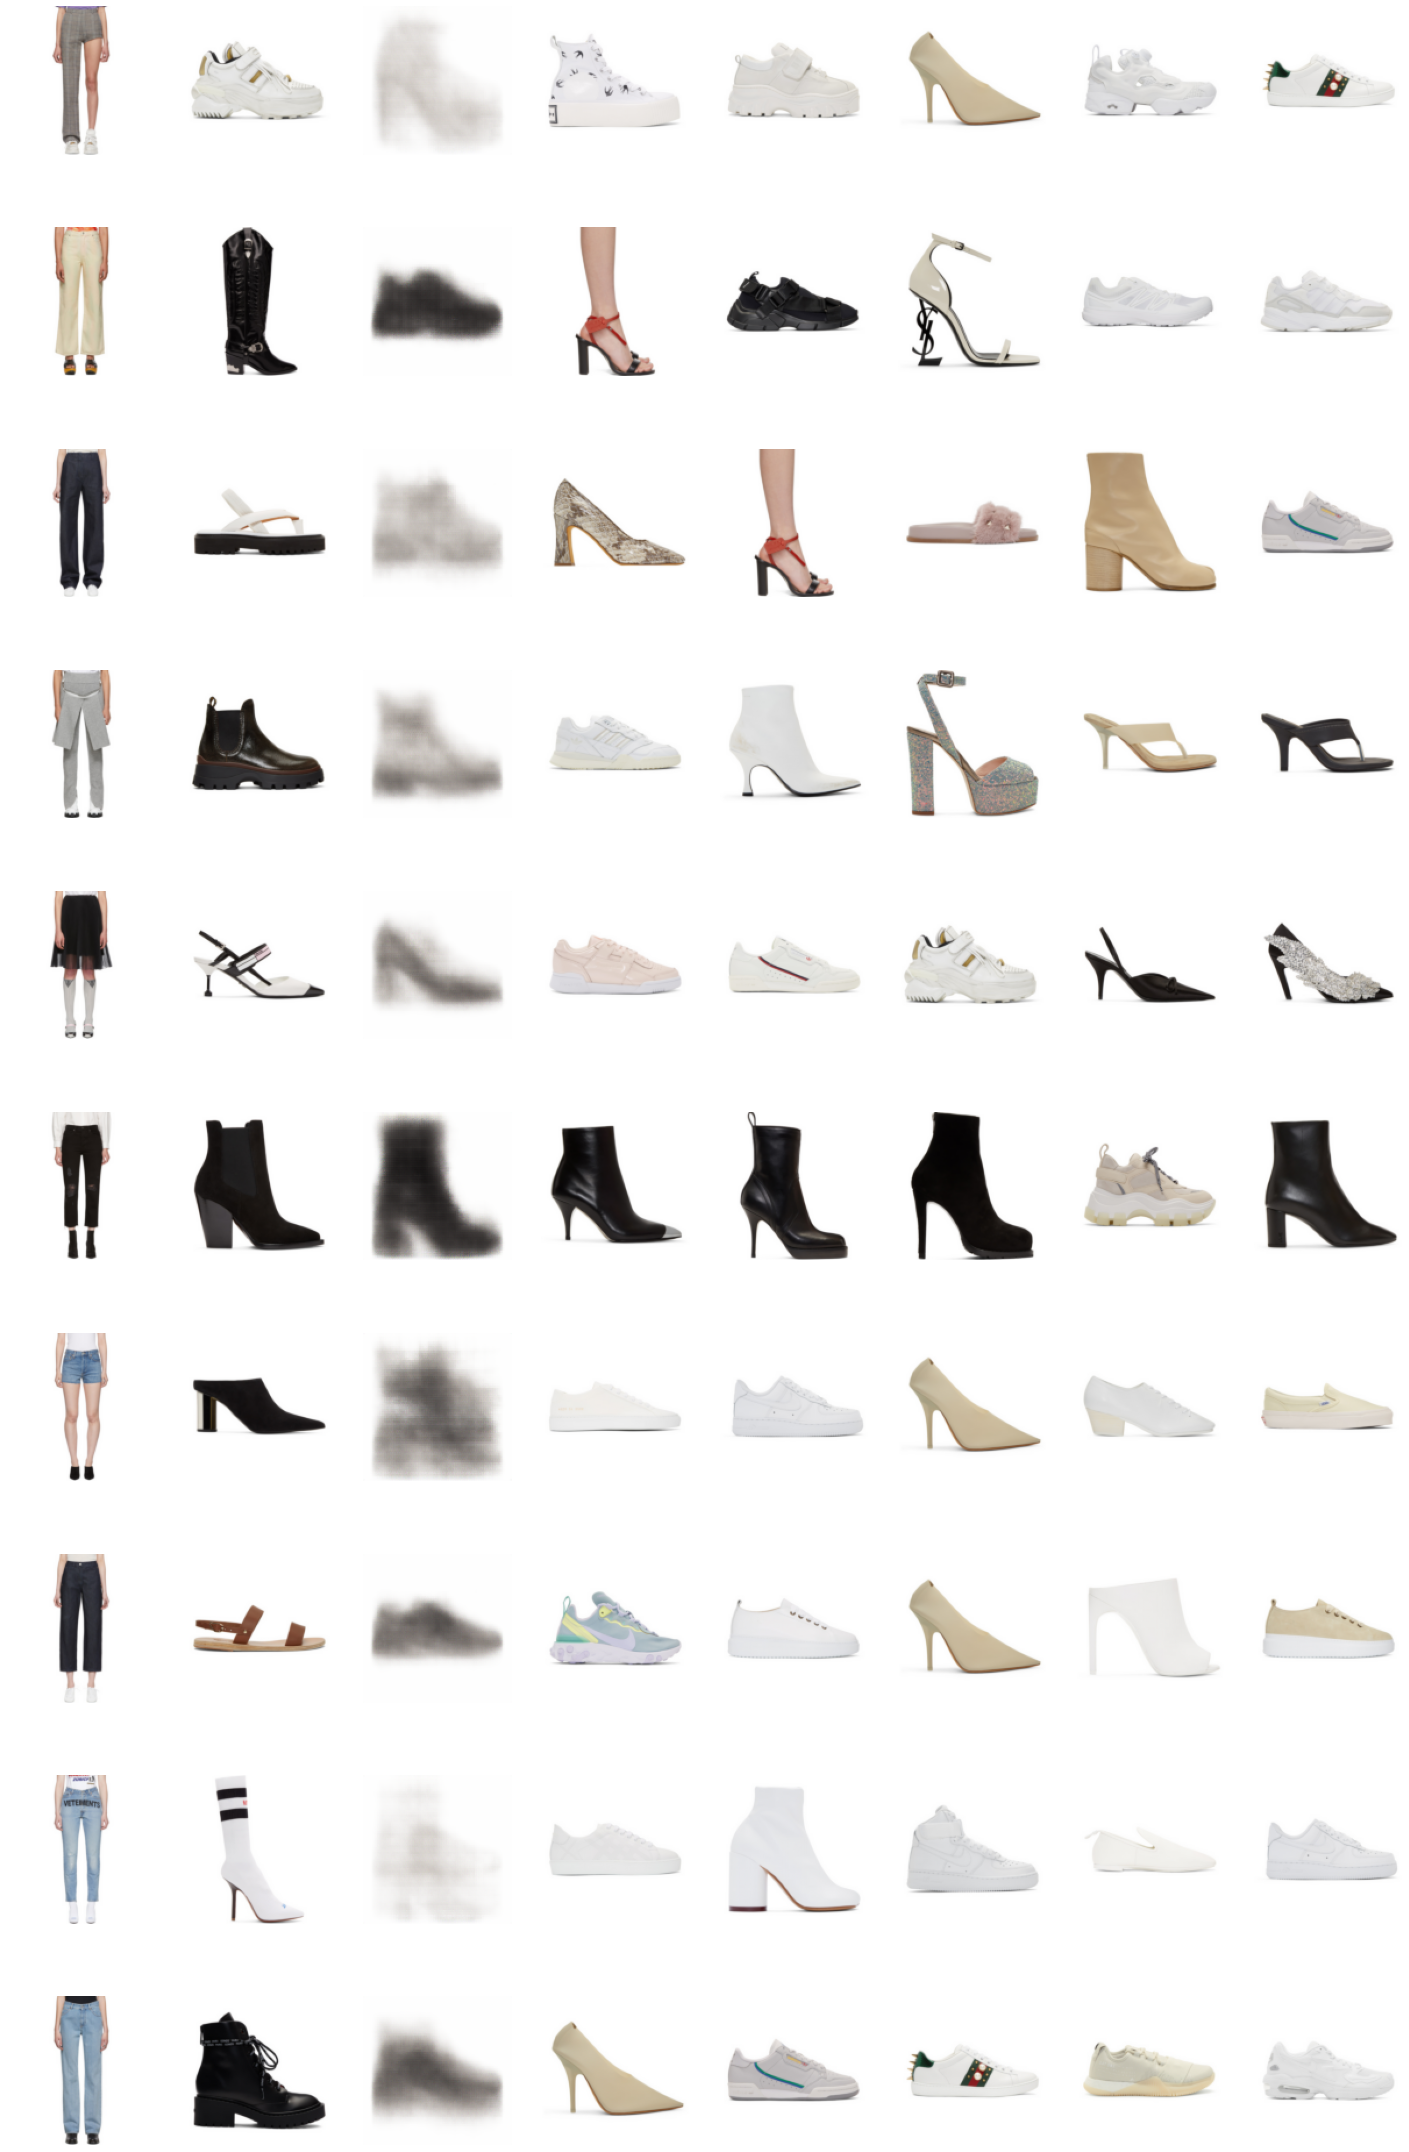

In [ ]:
plt.figure(figsize=(25, 40))
k = 10
num_items = 8
for i, (org, gt, res, emb) in enumerate(zip(orig[:k], ground_truth[:k], result[:k], embed[:k])):
    #gt = np.moveaxis(gt, 0, -1)
    res = np.moveaxis(res, 0, -1)
    org = np.moveaxis(org, 0, -1)

    plt.subplot(10, num_items, num_items*i+1)
    plt.axis('off')
    plt.imshow(org)
    plt.subplot(10, num_items, num_items*i+2)
    plt.axis('off')
    plt.imshow(gt)
    plt.subplot(10, num_items, num_items*i+3)
    plt.imshow(res)
    plt.axis('off')

    indices = find_k_neighbours(5, embeddings_shoes, emb)
    
    plt.subplot(10, num_items, num_items*i+4)
    plt.axis('off')
    plt.imshow(shoes_photos[indices[0]])

    plt.subplot(10, num_items, num_items*i+5)
    plt.axis('off')
    plt.imshow(shoes_photos[indices[1]])

    plt.subplot(10, num_items, num_items*i+6)
    plt.axis('off')
    plt.imshow(shoes_photos[indices[2]])

    plt.subplot(10, num_items, num_items*i+7)
    plt.axis('off')
    plt.imshow(shoes_photos[indices[3]])

    plt.subplot(10, num_items, num_items*i+8)
    plt.axis('off')
    plt.imshow(shoes_photos[indices[4]])